## **HEART FAILURE PREDICTION**

### **Context**
`Cardiovascular diseases `(CVDs) remain the leading cause of death globally, accounting for an estimated 17.9 million deaths annually, or 31% of all global mortality. The majority of these deaths — about `4 in every 5` — are due to heart attacks and strokes, with one-third occurring prematurely in individuals under the age of 70. These conditions arise due to complex interactions among genetic, behavioral, and physiological risk factors.

The early detection and prediction of heart disease — a major category within CVDs — can be significantly improved by analyzing key clinical and lifestyle-related indicators. 

The following features from the dataset play a crucial role in evaluating cardiovascular health and the risk of heart disease:


`Age`: The risk of developing heart disease increases with age. Aging leads to stiffening of arteries and accumulation of plaque, which narrows blood vessels and impairs circulation.

`Sex`: Biological sex influences heart disease risk. For instance, men generally have a higher risk of heart attacks earlier in life, while post-menopausal women see an increase in risk due to hormonal changes.

`ChestPainType`: Different types of chest pain (e.g., typical angina, atypical angina, non-anginal pain) are critical indicators. Chest discomfort is one of the most recognizable symptoms of coronary artery disease.

`RestingBP` (Resting Blood Pressure): High resting blood pressure (hypertension) increases the workload on the heart and damages artery walls, significantly raising the risk of heart attacks, strokes, and heart failure.

`Cholesterol`: Elevated cholesterol levels contribute to the buildup of plaques (atherosclerosis) in the arteries, restricting blood flow to the heart and brain — a direct cause of heart attacks and strokes.

`FastingBS` (Fasting Blood Sugar): A fasting blood sugar level greater than 120 mg/dl is considered a risk marker. Persistent high blood sugar (as seen in diabetes) damages blood vessels and nerves that control the heart.

`RestingECG (Resting Electrocardiogram Results)`: This assesses the electrical activity of the heart. Abnormal ECG findings may indicate structural or functional heart problems, such as left ventricular hypertrophy or arrhythmias.

`MaxHR (Maximum Heart Rate Achieved)`: This measures the heart’s ability to cope with physical activity. Abnormal maximum heart rate responses can indicate impaired cardiovascular function.

`ExerciseAngina`: The presence of angina (chest pain) induced by exercise suggests poor blood flow to the heart muscle during increased activity, a classic sign of coronary artery disease.

`Oldpeak`: This represents ST depression in ECG readings relative to rest, measured after exercise. It indicates how much the heart is strained during activity — the higher the value, the more likely the presence of ischemia (reduced blood flow).

`ST_Slope`: The slope of the ST segment on an ECG reflects changes in heart muscle activity during stress. Abnormal slopes can indicate myocardial ischemia or infarction.

`HeartDisease` (Target Variable): This indicates whether a person is diagnosed with heart disease or not. Using the above features, predictive models can assess the likelihood of heart disease presence.



`Libraries`

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

### **Prepare Data**

`Wrangle Fucntion`

In [3]:
def wrangle_data(filepath):
    # Load the dataset
    df = pd.read_csv('data/heart.csv')
    
    # Clean the data
    df.dropna(inplace=True)
    
    
    return df

In [4]:
df = wrangle_data('data/heart.csv')
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [5]:
df.shape

(918, 12)

In [10]:
df.columns

Index(['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS',
       'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope',
       'HeartDisease'],
      dtype='object')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


### **Explore**

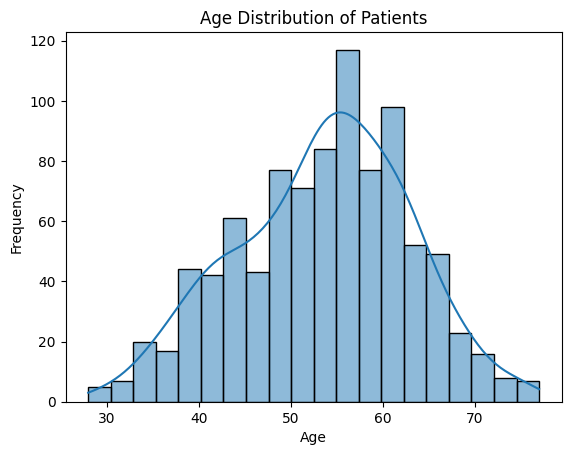

In [9]:
sns.histplot(data=df, x='Age',  bins=20, kde=True)
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Age Distribution of Patients');